In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import sys
from torch.autograd import Variable
from typing import Optional, Tuple
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [3]:
def show_mask(mask, ax, random_color=False,target_size=None):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    # resize the mask to target_size (if provided) (H,W) -> (target_size, target_size)
    if target_size:
        mask_image = cv2.resize(mask_image, (target_size, target_size))
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    



 ## Example image

In [5]:
image = cv2.imread('./person.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()


In [6]:
#sam_checkpoint = "sam_vit_h_4b8939.pth"
sam_checkpoint = "sam_vit_b_01ec64.pth"
model_type = "vit_b"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)


In [7]:
predictor.set_image(image)

input_point = np.array([[120, 170],[120,100]])
input_label = np.array([1,1])


In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  


In [ ]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
    return_logits=True,
)


In [ ]:
masks.shape  # (number_of_masks) x H x W


In [ ]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  


[[161.0982109  135.34925401]
 [180.80467781 142.73442511]]
3
1.0
1.0
1.0


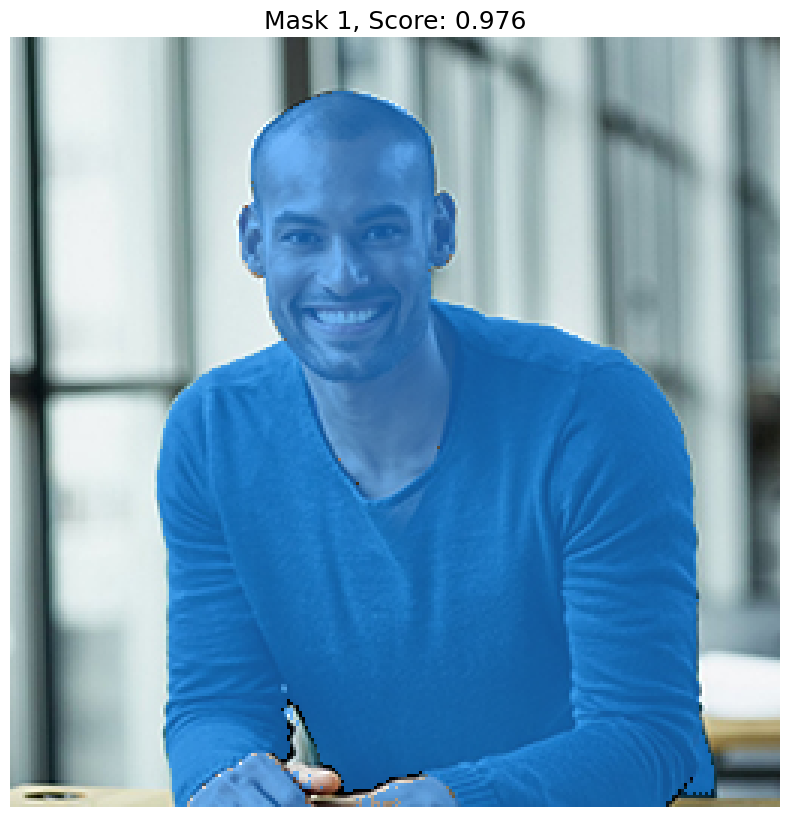

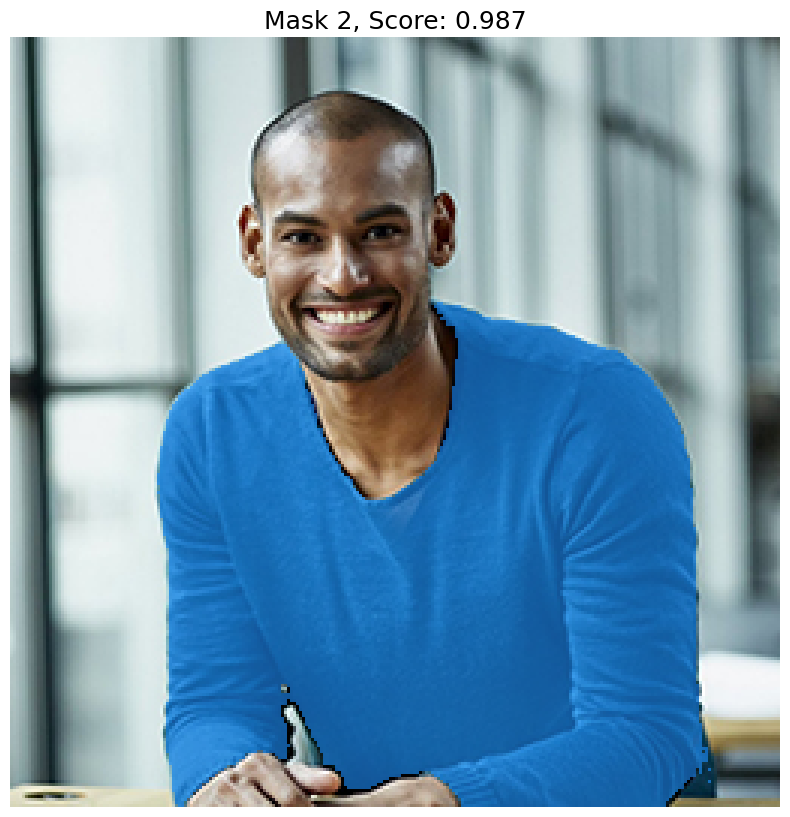

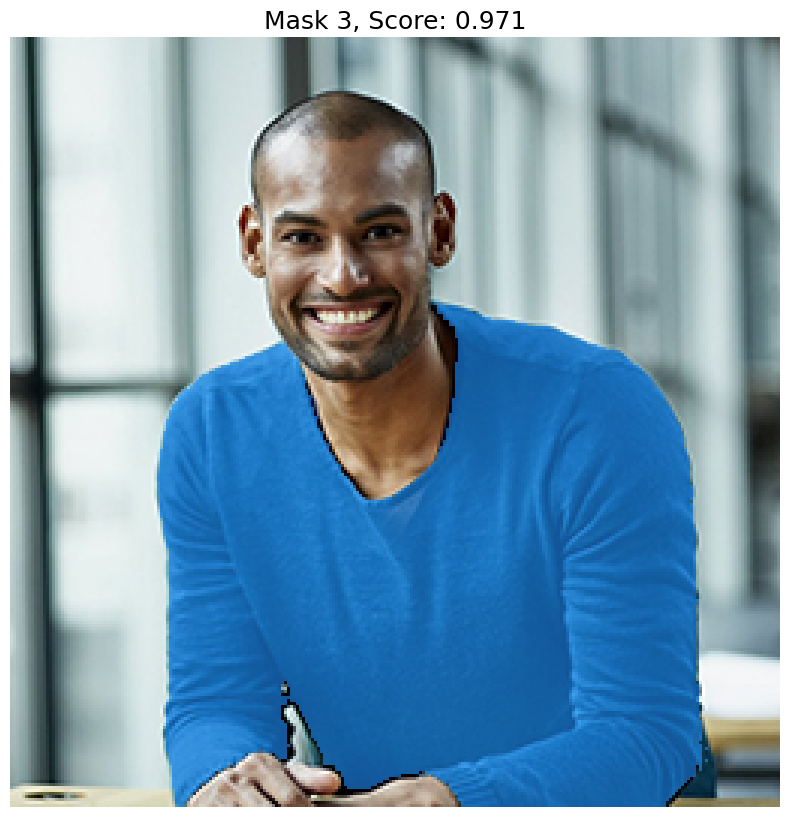

In [46]:

import os
mask_generator = SamAutomaticMaskGenerator(sam, min_mask_region_area=400)
#orginal_mask = np.copy(masks[0])

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

%matplotlib inline

def compare_images(path1, path2, predictor, mask_generator):
    image_original = cv2.imread(path1)
    image_original = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    image_modified  = cv2.imread(path2)
    image_modified = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    predictor.set_image(image_original)

    predictor.set_image(image_original)

    masks = mask_generator.generate(image_original)

    masks = sorted(masks, key=(lambda x: x['area']), reverse=True)[0:3]

    centers = []
    for mask in masks:
        indices = np.argwhere(mask["segmentation"])
        center = np.mean(indices, axis=0)
        if mask["segmentation"][int(center[0])][int(center[1])] == 1:
            centers.append(center)
        # print(center)

    # print(centers)

    centers = np.stack(centers, axis=0)

    print(centers)

    # plt.figure(figsize=(20,20))
    # plt.imshow(image)
    # show_anns(masks)
    # plt.axis('off')
    # plt.show()

    #show_mask(masks[0]["segmentation"])

    masks, scores, logits = predictor.predict(
    point_coords=centers,
    point_labels=[1] * len(centers),
    multimask_output=True,
    return_logits=False,
    )

    print(len(masks))

    predictor.set_image(image_modified)

    masks2, scores2, logits2 = predictor.predict(
    point_coords=centers,
    point_labels=[1] * len(centers),
    multimask_output=True,
    return_logits=False,
    )

    for (mask1,mask2) in zip(masks,masks2):
        print(np.sum(np.logical_and(mask1, mask2)) / np.sum(np.logical_or(mask1, mask2)))

    # for i, (mask, score) in enumerate(zip(masks, scores)):
    #     plt.figure(figsize=(10,10))
    #     plt.imshow(image)
    #     show_mask(mask, plt.gca())
    #     show_points(input_point, input_label, plt.gca())
    #     plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    #     plt.axis('off')
    #     plt.show()

    # fig, axs = plt.subplots(1, len(masks), figsize=(10, 10))

    # for i, (mask, score) in enumerate(zip(masks, scores)):
    #     ax = axs[i] if len(masks) > 1 else axs  # Use axs directly if there is only one mask
    #     ax.imshow(image)
    #     show_mask(mask, ax)
    #     show_points(centers, [1] * len(centers), ax)
    #     ax.set_title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    #     ax.axis('off')

    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10,10))
        plt.imshow(image)
        show_mask(mask, plt.gca())
        show_points(centers, [1] * len(centers), plt.gca())
        plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show() 
    
    # plt.show()

compare_images("./person.jpg", "./person.jpg", predictor, mask_generator)


In [ ]:
def main():
    # Check if the correct number of command-line arguments is provided
    if len(sys.argv) != 3:
        print("Usage: python script.py arg1 arg2")
        sys.exit(1)

    # Read the command-line arguments
    arg1 = sys.argv[1]
    arg2 = sys.argv[2]

    files = os.listdir(arg1)

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    sam_checkpoint = "sam_vit_b_01ec64.pth"
    model_type = "vit_b"

    sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
    sam.to(device=device)

    predictor = SamPredictor(sam)
    mask_generator = SamAutomaticMaskGenerator(sam)

    for filename in files:
        compare_images(os.path.join(arg1, filename), os.path.join(arg2, filename), predictor, mask_generator)
    

if __name__ == "__main__":
    main()